In [1]:
import os
import torch
import itertools
import numpy as np
import torch.nn as nn
from PIL import Image
import torch.utils.data
import torch.nn.parallel
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.datasets as dset
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torchvision import transforms
from typing import List, Tuple, Dict
from tqdm import tqdm
import random

In [2]:
# Decide which device we want to run on
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


* **Getting the train and test dataset**

In [4]:
# Define a classe de transformação
class Transform:
    def __init__(self):
        self.data_transform = transforms.Compose([transforms.ToTensor()])

    def __call__(self, inp):
        return self.data_transform(inp)

# Define a classe SeismicDataset para carregar dados binários
class SeismicDataset:
    def __init__(self, elastic_folder, acoustic_folder, shape=(256, 256, 1)):
        self.elastic_files = sorted([os.path.join(elastic_folder, f) for f in os.listdir(elastic_folder) if f.endswith('.bin')])
        self.acoustic_files = sorted([os.path.join(acoustic_folder, f) for f in os.listdir(acoustic_folder) if f.endswith('.bin')])
        self.transformer = Transform()

        # Define o tamanho dos patches com base no parâmetro `shape`
        self.patch_shape = shape

        # Verifica se o número de patches é o mesmo em ambas as pastas
        assert len(self.elastic_files) == len(self.acoustic_files), "Número de patches deve ser igual em ambas as pastas."

    def __len__(self):
        return len(self.elastic_files)

    def __getitem__(self, idx) -> Tuple[torch.Tensor, torch.Tensor]:
        # Carrega os patches binários para elastic e acoustic
        elastic_patch = np.fromfile(self.elastic_files[idx], dtype='float32').reshape(self.patch_shape)
        acoustic_patch = np.fromfile(self.acoustic_files[idx], dtype='float32').reshape(self.patch_shape)
        
        # Transforma para tensor
        elastic_patch = self.transformer(elastic_patch)
        acoustic_patch = self.transformer(acoustic_patch)

        return acoustic_patch, elastic_patch


# Define as pastas de treino e teste
train_elastic_path = r'C:\Users\Matheus\TrabalhodeMestrado\Redes_Neurais\Dados\Seismic_data_set\train\elastic_vx'
train_acoustic_path = r'C:\Users\Matheus\TrabalhodeMestrado\Redes_Neurais\Dados\Seismic_data_set\train\acoustic'
test_elastic_path = r'C:\Users\Matheus\TrabalhodeMestrado\Redes_Neurais\Dados\Seismic_data_set\test\elastic_vx'
test_acoustic_path = r'C:\Users\Matheus\TrabalhodeMestrado\Redes_Neurais\Dados\Seismic_data_set\test\acoustic'

# Cria o dataset e DataLoader para treino e teste
train_ds = SeismicDataset(train_elastic_path, train_acoustic_path, shape=(256, 256, 1))
test_ds = SeismicDataset(test_elastic_path, test_acoustic_path, shape=(768, 361, 1))

# Parâmetros do DataLoader
BATCH_SIZE_TRAIN = 4
BATCH_SIZE_TEST = 1

# DataLoaders
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE_TRAIN, shuffle=True, drop_last=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE_TEST, shuffle=False, drop_last=False)

print("DataLoaders de treino e teste criados com sucesso!")

DataLoaders de treino e teste criados com sucesso!


In [5]:
# Número total de patches no dataset de treino
num_train_patches = len(train_ds)
num_test_patches = len(test_ds)

# Número de batches no DataLoader
num_train_batches = len(train_dl)
num_test_batches = len(test_dl)

print(f"Número total de patches de treino: {num_train_patches}")
print(f"Número total de patches de teste: {num_test_patches}")
print(f"Número total de batches de treino: {num_train_batches}")
print(f"Número total de batches de teste: {num_test_batches}")

Número total de patches de treino: 3000
Número total de patches de teste: 61
Número total de batches de treino: 750
Número total de batches de teste: 61


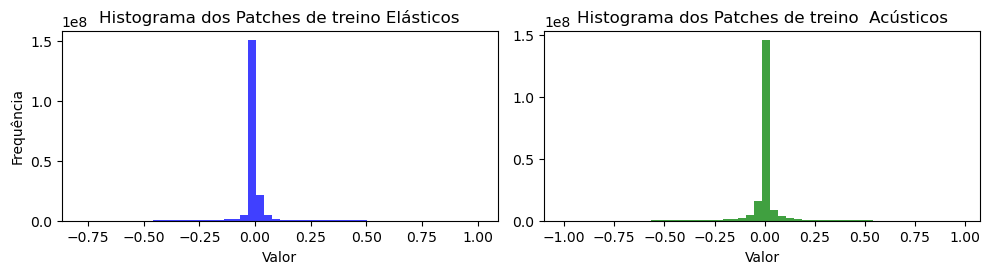

In [6]:
# Inicializar listas para armazenar os valores de todos os patches
all_elastic_values = []
all_acoustic_values = []

# Iterar sobre todo o DataLoader
for elastic_patch, acoustic_patch in train_dl:
    all_elastic_values.append(elastic_patch.numpy().flatten())
    all_acoustic_values.append(acoustic_patch.numpy().flatten())

# Concatenar todos os valores de todos os patches em um único array
all_elastic_values = np.concatenate(all_elastic_values)
all_acoustic_values = np.concatenate(all_acoustic_values)

# Plotar o histograma para os patches elásticos e acústicos
plt.figure(figsize=(10, 3))

# Histograma para os patches elásticos
plt.subplot(1, 2, 1)
plt.hist(all_elastic_values, bins=50, alpha=0.75, color='blue')
plt.title('Histograma dos Patches de treino Elásticos')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Histograma para os patches acústicos
plt.subplot(1, 2, 2)
plt.hist(all_acoustic_values, bins=50, alpha=0.75, color='green')
plt.title('Histograma dos Patches de treino  Acústicos')
plt.xlabel('Valor')

# Mostrar os gráficos
plt.tight_layout()
plt.show()

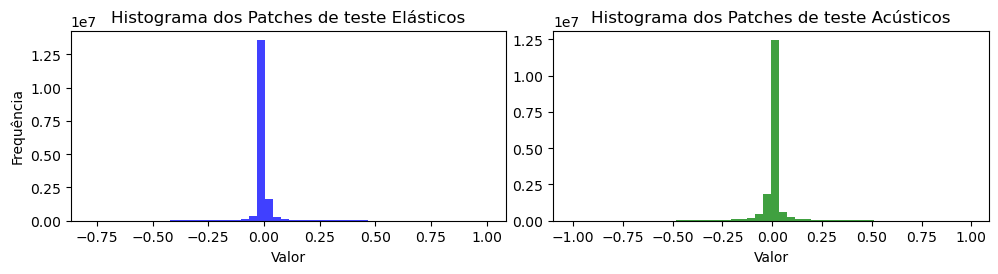

In [7]:
# Inicializar listas para armazenar os valores de todos os patches
all_elastic_values = []
all_acoustic_values = []

# Iterar sobre todo o DataLoader
for elastic_patch, acoustic_patch in test_dl:
    all_elastic_values.append(elastic_patch.numpy().flatten())
    all_acoustic_values.append(acoustic_patch.numpy().flatten())

# Concatenar todos os valores de todos os patches em um único array
all_elastic_values = np.concatenate(all_elastic_values)
all_acoustic_values = np.concatenate(all_acoustic_values)

# Plotar o histograma para os patches elásticos e acústicos
plt.figure(figsize=(10, 3))

# Histograma para os patches elásticos
plt.subplot(1, 2, 1)
plt.hist(all_elastic_values, bins=50, alpha=0.75, color='blue')
plt.title('Histograma dos Patches de teste Elásticos')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Histograma para os patches acústicos
plt.subplot(1, 2, 2)
plt.hist(all_acoustic_values, bins=50, alpha=0.75, color='green')
plt.title('Histograma dos Patches de teste Acústicos')
plt.xlabel('Valor')

# Mostrar os gráficos
plt.tight_layout()
plt.show()

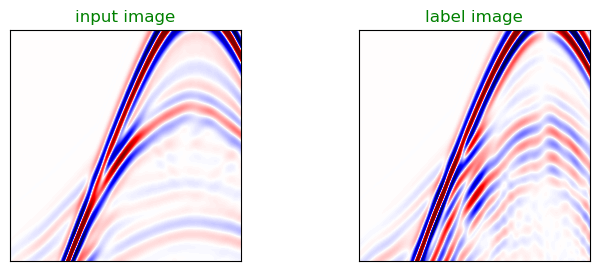

In [8]:
def show_img_sample(train_dl):
    for i, (real_input, real_target) in enumerate(train_dl):
        if i > 0:
            break
        fig, axes = plt.subplots(1, 2, figsize=(9, 3))
        ax = axes.ravel()
        
        perc = 99
        vmax = np.percentile(np.abs(real_input[0].squeeze()), perc)
        vmin = -vmax
        
        ax[0].imshow(real_input[0].squeeze(), cmap='seismic', vmin=vmin, vmax=vmax)
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[0].set_title("input image", c="g")
        ax[1].imshow(real_target[0].squeeze(), cmap='seismic',vmin=vmin, vmax=vmax)
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        ax[1].set_title("label image", c="g")
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()

show_img_sample(train_dl)

* **Define the generator and discriminator**

In [10]:
class GeneratorUnet(nn.Module):
    def __init__(self, in_channels):
        super(GeneratorUnet, self).__init__()
        self.down_stack = nn.ModuleList([
            self.Downsample(in_channels, 64, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
            self.Downsample(64, 128),  # (batch_size, 64, 64, 128)
            self.Downsample(128, 256),  # (batch_size, 32, 32, 256)
            self.Downsample(256, 512),  # (batch_size, 16, 16, 512)
            self.Downsample(512, 512),  # (batch_size, 8, 8, 512)
            self.Downsample(512, 512),  # (batch_size, 4, 4, 512)
            self.Downsample(512, 512),  # (batch_size, 2, 2, 512)
            self.Downsample(512, 512, apply_batchnorm=False),  # (batch_size, 1, 1, 512)
        ])

        self.up_stack = nn.ModuleList([
            self.Upsample(512, 512, apply_dropout=True),  # (batch_size, 2, 2, 1024)
            self.Upsample(1024, 512, apply_dropout=True),  # (batch_size, 4, 4, 1024)
            self.Upsample(1024, 512, apply_dropout=True),  # (batch_size, 8, 8, 1024)
            self.Upsample(1024, 512),  # (batch_size, 16, 16, 1024)
            self.Upsample(1024, 256),  # (batch_size, 32, 32, 512)
            self.Upsample(512, 128),  # (batch_size, 64, 64, 256)
            self.Upsample(256, 64),  # (batch_size, 128, 128, 128)
        ])

        self.last = nn.ConvTranspose2d(128, in_channels, kernel_size=4, stride=2, padding=1, bias=False)
        self.tanh = nn.Tanh()

    def Downsample(self, in_channels, out_channels, apply_batchnorm=True):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        if apply_batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))

        return nn.Sequential(*layers)

    def Upsample(self, in_channels, out_channels, apply_dropout=False):
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(inplace=True)
        ]
        if apply_dropout:
            layers.append(nn.Dropout(0.5))

        return nn.Sequential(*layers)

    def forward(self, x):
        skips = []
        for down in self.down_stack:
            x = down(x)
            skips.append(x)

        skips = reversed(skips[:-1])
        
        for up, skip in zip(self.up_stack, skips):
            x = up(x)
            x = torch.cat([x, skip], dim=1)

        x = self.last(x)
        x = self.tanh(x)
        return x

In [11]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            *self.block(in_channels, 64, normalize=False), # 3*256*256 -> 64*128*128 
            *self.block(64, 128),  # 64*128*128 -> 128*64*64
            *self.block(128, 256), # 128*64*64 -> 256*32*32     
            nn.ZeroPad2d(1), # padding left and top   256*32*32 -> 256*34*34
            nn.Conv2d(256, 512, 4, stride=1, bias=False), #256*34*34 -> 512*31*31
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ZeroPad2d(1), #512*31*31 -> 512*33*33
            nn.Conv2d(512, 1, 4) #512*33*33 -> 1*30*30
        )
    
    @staticmethod
    def block(in_channels, out_channels, normalize=True):
        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        return layers
        
    def forward(self, input, target):
        x = torch.cat((input, target), dim=1)
        return self.model(x)

* **Define the Loss**

In [13]:
criterion_L1  = nn.L1Loss() # Perda L1
criterion_GAN = nn.BCEWithLogitsLoss() # Perda quadrática

* **Inicializando os modelos na GPU**

In [15]:
G = GeneratorUnet(1)
D = Discriminator(2)

In [16]:
cuda = torch.cuda.is_available()
print(f'cuda: {cuda}')

if cuda:
    G = G.cuda()
    D = D.cuda()
    
    criterion_L1 = criterion_L1.cuda()
    criterion_GAN = criterion_GAN.cuda()

cuda: True


In [17]:
def visualize_data(generator, discriminator, dataloader, title, device):
    generator.eval()  # Coloca o gerador no modo de avaliação
    discriminator.eval()  # Coloca o discriminador no modo de avaliação

    # Itera através do dataloader
    for i, (real_input, real_target) in enumerate(dataloader):
        if i > 0:
          break

        real_input, real_target = real_input.to(device), real_target.to(device)

        # Gera imagens falsas com o gerador
        with torch.no_grad():
            fake_image = generator(real_input)

        # Avalia as imagens reais e falsas com o discriminador
        real_output = discriminator(real_input,real_target)
        fake_output = discriminator(real_input,fake_image.detach())

        print(f'shape da saída do gerador {fake_image.shape}')
        print(f'shape da saída do discriminador {fake_output.shape}')

        # Visualiza os resultados
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f'{title}')

        real_input_img = real_input[0].squeeze().cpu()
        real_target_img = real_target[0].squeeze().cpu()
        fake_image_img = fake_image[0].squeeze().cpu()

        perc = 99
        vmax = np.percentile(np.abs(real_input_img), perc)
        vmin = -vmax

       # Mostra a imagem de entrada (real)
        im1 = ax[0].imshow(real_input_img, cmap='seismic',vmin=vmin, vmax=vmax)
        ax[0].set_title('Real Input', c="g")
        ax[0].axis('off')

        # Mostra a imagem real alvo (ground truth)
        im2 = ax[1].imshow(real_target_img, cmap='seismic',vmin=vmin, vmax=vmax)
        ax[1].set_title('Real Target', c="g")
        ax[1].axis('off')

        # Mostra a imagem falsa gerada
        im3 = ax[2].imshow(fake_image_img, cmap='seismic',vmin=vmin, vmax=vmax)
        ax[2].set_title('Generated Image', c="g")
        ax[2].axis('off')

        plt.tight_layout()
        plt.show()

shape da saída do gerador torch.Size([4, 1, 256, 256])
shape da saída do discriminador torch.Size([4, 1, 30, 30])


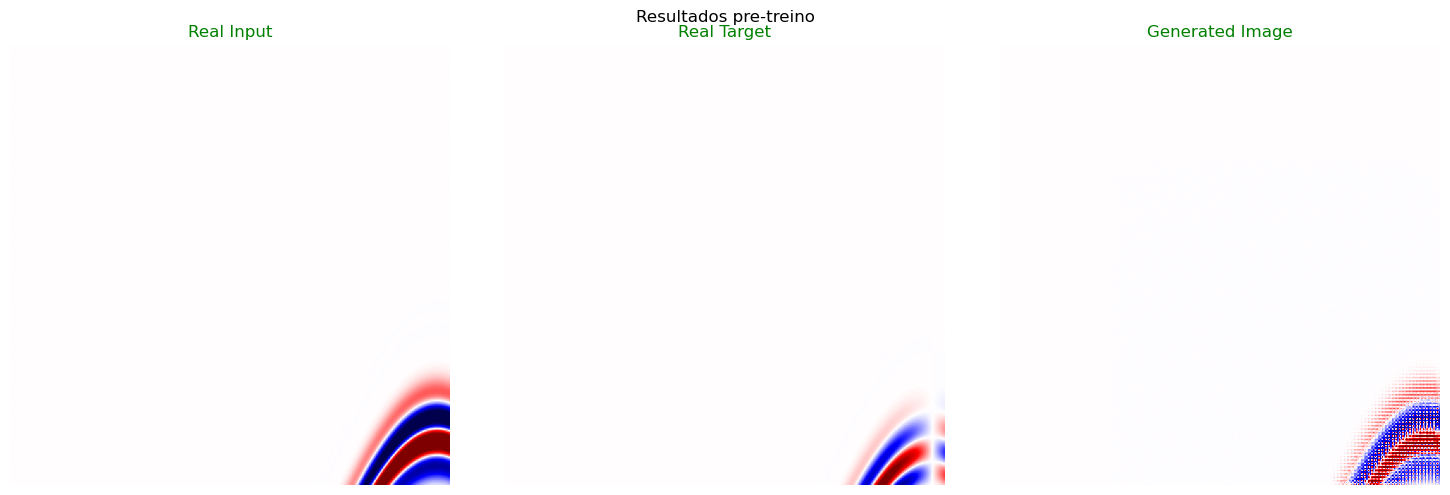

In [18]:
visualize_data(G, D, train_dl, 'Resultados pre-treino', device)

In [19]:
lr_G = 2e-4
lr_D = 2e-4
b1 = 0.5
b2 = 0.999

optimizer_G = torch.optim.Adam(G.parameters(), lr=lr_G, betas=(b1, b2))
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr_D, betas=(b1, b2))

In [20]:
n_epoches = 120
G_losses, D_losses, L1_losses, GAN_losses = [], [], [], []

for epoch in range(n_epoches):

    G.train()
    D.train()
    LAMBDA = 1000

    for i, (input, target) in enumerate(tqdm(train_dl)):
        it = i+1
        input, target = input.to(device), target.to(device)

        real_label = torch.ones_like(D(input, target), device=device)  # Rótulo para imagens reais
        fake_label = torch.zeros_like(D(input, target), device=device) 
        
        fake_image = G(input)
        fake_image_ = fake_image.detach()

        """Train Generators"""
        # set to training mode in the begining, because sample_images will set it to eval mode

        optimizer_G.zero_grad()

        # GAN loss, train G to make D think it's true
        loss_L1 = criterion_L1(fake_image, target)
        loss_GAN = criterion_GAN(D(input, fake_image), real_label) 
        # Não pode usar o fake_image_ aqui, pois o gerador precisa calcular o gradiente com base na imagem fake
        
        # G total loss
        loss_G = loss_GAN + LAMBDA * loss_L1 

        loss_G.backward()
        optimizer_G.step()

        #if it % 2 == 0:
            
        """Train Discriminator """
        optimizer_D.zero_grad()
        
        loss_real = criterion_GAN(D(input, target), real_label)
        loss_fake = criterion_GAN(D(input, fake_image_), fake_label)
        loss_D = (loss_real + loss_fake) * 0.5
        
        loss_D.backward()
        optimizer_D.step()

    # Salvar as perdas para cada época
    G_losses.append(loss_G.item())
    D_losses.append(loss_D.item())
    GAN_losses.append(loss_GAN.item())
    L1_losses.append(loss_L1.item())

    print(f'[Epoch {epoch + 1}/{n_epoches}]')
    print(f'[G loss: {loss_G.item()} | GAN: {loss_GAN.item()} L1: {loss_L1.item()}]')
    print(f'[D loss: {loss_D.item()}]')

100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.31it/s]


[Epoch 1/120]
[G loss: 41.839393615722656 | GAN: 6.069506645202637 L1: 0.03576988726854324]
[D loss: 0.0170796737074852]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.43it/s]


[Epoch 2/120]
[G loss: 12.746304512023926 | GAN: 2.399625539779663 L1: 0.010346679016947746]
[D loss: 0.2661360502243042]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.43it/s]


[Epoch 3/120]
[G loss: 18.901891708374023 | GAN: 3.414856195449829 L1: 0.015487035736441612]
[D loss: 0.19041715562343597]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.42it/s]


[Epoch 4/120]
[G loss: 21.838653564453125 | GAN: 0.7452555298805237 L1: 0.021093396469950676]
[D loss: 0.47495704889297485]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.41it/s]


[Epoch 5/120]
[G loss: 15.320253372192383 | GAN: 5.706729888916016 L1: 0.00961352325975895]
[D loss: 0.02752324938774109]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:58<00:00, 12.90it/s]


[Epoch 6/120]
[G loss: 11.171374320983887 | GAN: 0.6845529675483704 L1: 0.010486820712685585]
[D loss: 0.8280563950538635]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:58<00:00, 12.82it/s]


[Epoch 7/120]
[G loss: 11.762504577636719 | GAN: 4.588386058807373 L1: 0.007174118421971798]
[D loss: 0.012430444359779358]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.29it/s]


[Epoch 8/120]
[G loss: 14.852127075195312 | GAN: 2.5289957523345947 L1: 0.012323131784796715]
[D loss: 0.513360857963562]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.27it/s]


[Epoch 9/120]
[G loss: 8.73876953125 | GAN: 4.5471978187561035 L1: 0.004191571846604347]
[D loss: 0.007840055041015148]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:59<00:00, 12.60it/s]


[Epoch 10/120]
[G loss: 11.04733657836914 | GAN: 5.453983306884766 L1: 0.005593353416770697]
[D loss: 0.006065758876502514]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.18it/s]


[Epoch 11/120]
[G loss: 9.556252479553223 | GAN: 5.814511299133301 L1: 0.0037417414132505655]
[D loss: 0.017395421862602234]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.04it/s]


[Epoch 12/120]
[G loss: 13.188066482543945 | GAN: 7.690160274505615 L1: 0.005497905891388655]
[D loss: 0.00862234178930521]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.11it/s]


[Epoch 13/120]
[G loss: 8.493349075317383 | GAN: 5.067989349365234 L1: 0.003425359958782792]
[D loss: 0.008403663523495197]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 12.94it/s]


[Epoch 14/120]
[G loss: 12.384960174560547 | GAN: 6.9032769203186035 L1: 0.005481683649122715]
[D loss: 0.002976102288812399]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.13it/s]


[Epoch 15/120]
[G loss: 7.8491692543029785 | GAN: 0.6879333853721619 L1: 0.007161235902458429]
[D loss: 0.6784950494766235]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.11it/s]


[Epoch 16/120]
[G loss: 12.415512084960938 | GAN: 7.983320713043213 L1: 0.004432191140949726]
[D loss: 0.0012502705212682486]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.09it/s]


[Epoch 17/120]
[G loss: 12.828363418579102 | GAN: 6.739249229431152 L1: 0.006089113652706146]
[D loss: 0.0031060082837939262]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.10it/s]


[Epoch 18/120]
[G loss: 9.602460861206055 | GAN: 6.193967342376709 L1: 0.0034084939397871494]
[D loss: 0.021148573607206345]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.12it/s]


[Epoch 19/120]
[G loss: 7.535152435302734 | GAN: 5.279816627502441 L1: 0.0022553359158337116]
[D loss: 0.010289687663316727]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.13it/s]


[Epoch 20/120]
[G loss: 13.615007400512695 | GAN: 9.667487144470215 L1: 0.003947519697248936]
[D loss: 0.0003715254715643823]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.21it/s]


[Epoch 21/120]
[G loss: 11.090747833251953 | GAN: 5.223390579223633 L1: 0.005867357831448317]
[D loss: 0.015352895483374596]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.13it/s]


[Epoch 22/120]
[G loss: 12.288335800170898 | GAN: 9.011301040649414 L1: 0.003277034964412451]
[D loss: 0.0004999787779524922]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.12it/s]


[Epoch 23/120]
[G loss: 9.512389183044434 | GAN: 5.115878105163574 L1: 0.0043965112417936325]
[D loss: 0.005276935175061226]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.12it/s]


[Epoch 24/120]
[G loss: 13.609709739685059 | GAN: 8.705324172973633 L1: 0.004904385656118393]
[D loss: 0.0006571655976586044]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.11it/s]


[Epoch 25/120]
[G loss: 9.230819702148438 | GAN: 6.337728023529053 L1: 0.0028930911794304848]
[D loss: 0.0017394255846738815]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.11it/s]


[Epoch 26/120]
[G loss: 13.37311840057373 | GAN: 9.660399436950684 L1: 0.0037127190735191107]
[D loss: 0.0003056363493669778]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.12it/s]


[Epoch 27/120]
[G loss: 6.613396644592285 | GAN: 0.9643065333366394 L1: 0.005649090278893709]
[D loss: 0.39008408784866333]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.12it/s]


[Epoch 28/120]
[G loss: 3.4864389896392822 | GAN: 3.0223145484924316 L1: 0.000464124430436641]
[D loss: 0.09559611976146698]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.12it/s]


[Epoch 29/120]
[G loss: 14.360651969909668 | GAN: 9.588899612426758 L1: 0.004771752282977104]
[D loss: 0.0011772429570555687]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.12it/s]


[Epoch 30/120]
[G loss: 9.841432571411133 | GAN: 7.145659446716309 L1: 0.0026957732625305653]
[D loss: 0.0016631514299660921]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.12it/s]


[Epoch 31/120]
[G loss: 15.134702682495117 | GAN: 10.12231731414795 L1: 0.005012385547161102]
[D loss: 0.0008302145870402455]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.13it/s]


[Epoch 32/120]
[G loss: 12.978744506835938 | GAN: 7.949583530426025 L1: 0.005029160529375076]
[D loss: 0.0062102978117764]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.13it/s]


[Epoch 33/120]
[G loss: 12.416028022766113 | GAN: 9.347760200500488 L1: 0.0030682676006108522]
[D loss: 0.0008444873965345323]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.18it/s]


[Epoch 34/120]
[G loss: 11.800432205200195 | GAN: 8.253628730773926 L1: 0.0035468037240207195]
[D loss: 0.0005660703754983842]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.13it/s]


[Epoch 35/120]
[G loss: 11.440193176269531 | GAN: 6.969019412994385 L1: 0.004471174441277981]
[D loss: 0.002604007488116622]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.12it/s]


[Epoch 36/120]
[G loss: 12.356487274169922 | GAN: 7.589318752288818 L1: 0.004767168313264847]
[D loss: 0.0016000738833099604]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.12it/s]


[Epoch 37/120]
[G loss: 6.333636283874512 | GAN: 3.8429031372070312 L1: 0.002490732818841934]
[D loss: 0.03002934716641903]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.12it/s]


[Epoch 38/120]
[G loss: 11.150819778442383 | GAN: 8.37395191192627 L1: 0.0027768684085458517]
[D loss: 0.0005233809933997691]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.11it/s]


[Epoch 39/120]
[G loss: 6.757197380065918 | GAN: 2.6947386264801025 L1: 0.004062458872795105]
[D loss: 0.11807787418365479]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.11it/s]


[Epoch 40/120]
[G loss: 8.717569351196289 | GAN: 6.121119976043701 L1: 0.00259644933976233]
[D loss: 0.0035491222515702248]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.09it/s]


[Epoch 41/120]
[G loss: 11.27698040008545 | GAN: 9.221881866455078 L1: 0.0020550985354930162]
[D loss: 0.00046199746429920197]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.11it/s]


[Epoch 42/120]
[G loss: 9.358451843261719 | GAN: 5.652870178222656 L1: 0.003705581184476614]
[D loss: 0.0032840371131896973]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.14it/s]


[Epoch 43/120]
[G loss: 4.382367134094238 | GAN: 3.5629162788391113 L1: 0.0008194505935534835]
[D loss: 0.02758740819990635]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.13it/s]


[Epoch 44/120]
[G loss: 6.7677717208862305 | GAN: 5.679938793182373 L1: 0.0010878329630941153]
[D loss: 0.009426744654774666]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.13it/s]


[Epoch 45/120]
[G loss: 11.37014389038086 | GAN: 8.727452278137207 L1: 0.0026426920667290688]
[D loss: 0.000632782350294292]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.12it/s]


[Epoch 46/120]
[G loss: 9.676918029785156 | GAN: 7.32521390914917 L1: 0.002351704053580761]
[D loss: 0.0013253854122012854]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.12it/s]


[Epoch 47/120]
[G loss: 3.984893321990967 | GAN: 0.8615318536758423 L1: 0.0031233616173267365]
[D loss: 0.7223021984100342]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.12it/s]


[Epoch 48/120]
[G loss: 8.84104061126709 | GAN: 6.656423568725586 L1: 0.0021846171002835035]
[D loss: 0.0014824401587247849]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.12it/s]


[Epoch 49/120]
[G loss: 14.03236198425293 | GAN: 9.795284271240234 L1: 0.004237078130245209]
[D loss: 0.00012692424934357405]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.12it/s]


[Epoch 50/120]
[G loss: 14.994382858276367 | GAN: 10.878220558166504 L1: 0.004116161726415157]
[D loss: 0.00012383295688778162]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.12it/s]


[Epoch 51/120]
[G loss: 8.755097389221191 | GAN: 6.801342487335205 L1: 0.0019537550397217274]
[D loss: 0.001234895084053278]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.12it/s]


[Epoch 52/120]
[G loss: 18.085315704345703 | GAN: 14.487879753112793 L1: 0.0035974355414509773]
[D loss: 2.2131129298941232e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.10it/s]


[Epoch 53/120]
[G loss: 14.717243194580078 | GAN: 11.032831192016602 L1: 0.0036844119895249605]
[D loss: 0.0001678491971688345]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 54/120]
[G loss: 12.054168701171875 | GAN: 9.053070068359375 L1: 0.003001098521053791]
[D loss: 0.000689957698341459]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.50it/s]


[Epoch 55/120]
[G loss: 12.16524887084961 | GAN: 9.025053024291992 L1: 0.003140196204185486]
[D loss: 0.0007932290900498629]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.50it/s]


[Epoch 56/120]
[G loss: 16.966899871826172 | GAN: 13.011979103088379 L1: 0.003954920917749405]
[D loss: 0.00026887678541243076]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 57/120]
[G loss: 4.762776851654053 | GAN: 1.6749132871627808 L1: 0.003087863326072693]
[D loss: 0.6154824495315552]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 58/120]
[G loss: 10.804451942443848 | GAN: 8.433445930480957 L1: 0.002371006179600954]
[D loss: 0.0004521273076534271]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.50it/s]


[Epoch 59/120]
[G loss: 12.472182273864746 | GAN: 9.150851249694824 L1: 0.0033213309943675995]
[D loss: 0.00032145652221515775]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 60/120]
[G loss: 12.182437896728516 | GAN: 9.231995582580566 L1: 0.0029504424892365932]
[D loss: 0.00013998281792737544]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.50it/s]


[Epoch 61/120]
[G loss: 14.16519832611084 | GAN: 10.11716365814209 L1: 0.0040480345487594604]
[D loss: 0.003493574447929859]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 62/120]
[G loss: 11.94276237487793 | GAN: 9.415416717529297 L1: 0.0025273452047258615]
[D loss: 0.00019201729446649551]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.48it/s]


[Epoch 63/120]
[G loss: 11.735383987426758 | GAN: 9.645727157592773 L1: 0.0020896573550999165]
[D loss: 0.00022829796944279224]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 64/120]
[G loss: 11.015751838684082 | GAN: 8.669585227966309 L1: 0.0023461664095520973]
[D loss: 0.0004284160095266998]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 65/120]
[G loss: 10.59705638885498 | GAN: 7.6980204582214355 L1: 0.0028990355785936117]
[D loss: 0.0005064107244834304]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 66/120]
[G loss: 12.225846290588379 | GAN: 9.226346969604492 L1: 0.0029994994401931763]
[D loss: 0.00014574493980035186]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 67/120]
[G loss: 13.21281623840332 | GAN: 9.848787307739258 L1: 0.0033640293404459953]
[D loss: 8.729016553843394e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 68/120]
[G loss: 15.588912010192871 | GAN: 11.336627006530762 L1: 0.00425228476524353]
[D loss: 5.931187843088992e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 69/120]
[G loss: 7.567296028137207 | GAN: 3.898634433746338 L1: 0.003668661694973707]
[D loss: 0.022767644375562668]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 70/120]
[G loss: 7.654462814331055 | GAN: 4.269905090332031 L1: 0.0033845577854663134]
[D loss: 0.011810296215116978]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 71/120]
[G loss: 15.792632102966309 | GAN: 12.569148063659668 L1: 0.0032234839163720608]
[D loss: 0.00026085632271133363]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 72/120]
[G loss: 10.89290714263916 | GAN: 9.365425109863281 L1: 0.001527481945231557]
[D loss: 0.00022073456784710288]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.48it/s]


[Epoch 73/120]
[G loss: 14.970518112182617 | GAN: 10.420182228088379 L1: 0.004550335928797722]
[D loss: 0.00015162350609898567]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 74/120]
[G loss: 19.472362518310547 | GAN: 14.57618522644043 L1: 0.004896178375929594]
[D loss: 8.968413021648303e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 75/120]
[G loss: 9.690570831298828 | GAN: 6.647322177886963 L1: 0.0030432483181357384]
[D loss: 0.002715136855840683]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.48it/s]


[Epoch 76/120]
[G loss: 16.300243377685547 | GAN: 12.381858825683594 L1: 0.003918384201824665]
[D loss: 0.00040787970647215843]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.50it/s]


[Epoch 77/120]
[G loss: 11.311412811279297 | GAN: 9.137079238891602 L1: 0.0021743332035839558]
[D loss: 0.0004057839687447995]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.48it/s]


[Epoch 78/120]
[G loss: 14.607564926147461 | GAN: 11.924382209777832 L1: 0.0026831827126443386]
[D loss: 0.00010999358346452937]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 79/120]
[G loss: 15.987741470336914 | GAN: 11.98461627960205 L1: 0.00400312477722764]
[D loss: 0.00012426121975295246]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 80/120]
[G loss: 14.714076042175293 | GAN: 10.63052749633789 L1: 0.0040835486724972725]
[D loss: 5.234270793152973e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 81/120]
[G loss: 10.503475189208984 | GAN: 7.999443531036377 L1: 0.002504031639546156]
[D loss: 0.0005652440013363957]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 82/120]
[G loss: 15.472696304321289 | GAN: 10.148024559020996 L1: 0.005324672441929579]
[D loss: 0.00013491381832864136]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 83/120]
[G loss: 8.044595718383789 | GAN: 7.0758585929870605 L1: 0.0009687371202744544]
[D loss: 0.0029562427662312984]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 84/120]
[G loss: 7.620078086853027 | GAN: 3.841878890991211 L1: 0.0037781991995871067]
[D loss: 0.43105947971343994]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 85/120]
[G loss: 14.710448265075684 | GAN: 11.523080825805664 L1: 0.00318736769258976]
[D loss: 0.0002325469395145774]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 86/120]
[G loss: 13.26223087310791 | GAN: 9.336777687072754 L1: 0.003925453405827284]
[D loss: 0.000236051288084127]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 87/120]
[G loss: 13.01144790649414 | GAN: 9.705225944519043 L1: 0.0033062221482396126]
[D loss: 0.0004029006522614509]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 88/120]
[G loss: 12.135774612426758 | GAN: 9.143702507019043 L1: 0.0029920723754912615]
[D loss: 0.00026759313186630607]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 89/120]
[G loss: 15.568519592285156 | GAN: 12.217576026916504 L1: 0.003350943559780717]
[D loss: 0.000246610667090863]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 90/120]
[G loss: 14.725415229797363 | GAN: 12.433389663696289 L1: 0.0022920253686606884]
[D loss: 5.2553230489138514e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 91/120]
[G loss: 14.387473106384277 | GAN: 12.329429626464844 L1: 0.002058043610304594]
[D loss: 0.0006840654532425106]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.48it/s]


[Epoch 92/120]
[G loss: 3.3374032974243164 | GAN: 1.1950985193252563 L1: 0.002142304554581642]
[D loss: 0.23915664851665497]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 93/120]
[G loss: 10.359299659729004 | GAN: 7.2818145751953125 L1: 0.0030774851329624653]
[D loss: 0.0008428474538959563]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.50it/s]


[Epoch 94/120]
[G loss: 15.633121490478516 | GAN: 11.69969367980957 L1: 0.003933427855372429]
[D loss: 0.00016127282287925482]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 95/120]
[G loss: 12.138564109802246 | GAN: 9.672988891601562 L1: 0.00246557523496449]
[D loss: 0.00699820788577199]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 96/120]
[G loss: 12.274351119995117 | GAN: 9.996720314025879 L1: 0.002277631312608719]
[D loss: 0.00014363444643095136]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.48it/s]


[Epoch 97/120]
[G loss: 13.57861328125 | GAN: 11.047383308410645 L1: 0.002531229518353939]
[D loss: 0.00010690761700971052]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 98/120]
[G loss: 12.736656188964844 | GAN: 8.602265357971191 L1: 0.004134390968829393]
[D loss: 0.0004451906424947083]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 99/120]
[G loss: 17.124515533447266 | GAN: 14.031391143798828 L1: 0.0030931239016354084]
[D loss: 0.00011710054968716577]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.50it/s]


[Epoch 100/120]
[G loss: 13.175421714782715 | GAN: 10.039229393005371 L1: 0.003136192448437214]
[D loss: 8.881920075509697e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.50it/s]


[Epoch 101/120]
[G loss: 13.42155933380127 | GAN: 10.24953556060791 L1: 0.0031720236875116825]
[D loss: 5.402477836469188e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.50it/s]


[Epoch 102/120]
[G loss: 14.265636444091797 | GAN: 10.088309288024902 L1: 0.004177327733486891]
[D loss: 8.758769399719313e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.50it/s]


[Epoch 103/120]
[G loss: 13.614978790283203 | GAN: 9.976313591003418 L1: 0.0036386647261679173]
[D loss: 6.71031084493734e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.49it/s]


[Epoch 104/120]
[G loss: 14.576359748840332 | GAN: 11.08842945098877 L1: 0.0034879306331276894]
[D loss: 2.5476443624938838e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.50it/s]


[Epoch 105/120]
[G loss: 16.607797622680664 | GAN: 12.747716903686523 L1: 0.003860080149024725]
[D loss: 1.5338086086558178e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.50it/s]


[Epoch 106/120]
[G loss: 9.369170188903809 | GAN: 7.558073043823242 L1: 0.001811097259633243]
[D loss: 0.0011886702850461006]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.45it/s]


[Epoch 107/120]
[G loss: 12.754779815673828 | GAN: 8.689006805419922 L1: 0.004065772984176874]
[D loss: 0.0007326104678213596]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.09it/s]


[Epoch 108/120]
[G loss: 13.844730377197266 | GAN: 8.891246795654297 L1: 0.004953484050929546]
[D loss: 0.0020030296873301268]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.09it/s]


[Epoch 109/120]
[G loss: 15.910053253173828 | GAN: 12.156596183776855 L1: 0.0037534574512392282]
[D loss: 0.00015722082753200084]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.15it/s]


[Epoch 110/120]
[G loss: 13.592504501342773 | GAN: 11.121150016784668 L1: 0.002471354091539979]
[D loss: 5.729105760110542e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.20it/s]


[Epoch 111/120]
[G loss: 15.514543533325195 | GAN: 11.946431159973145 L1: 0.0035681126173585653]
[D loss: 1.6057614629971795e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.13it/s]


[Epoch 112/120]
[G loss: 10.999432563781738 | GAN: 8.623140335083008 L1: 0.002376291900873184]
[D loss: 0.0004014875157736242]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.13it/s]


[Epoch 113/120]
[G loss: 13.19617748260498 | GAN: 9.837080001831055 L1: 0.003359097521752119]
[D loss: 8.873437764123082e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.08it/s]


[Epoch 114/120]
[G loss: 12.525614738464355 | GAN: 9.561393737792969 L1: 0.002964220941066742]
[D loss: 0.0004406902880873531]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.04it/s]


[Epoch 115/120]
[G loss: 7.4223809242248535 | GAN: 4.4425811767578125 L1: 0.0029797996394336224]
[D loss: 0.027808895334601402]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.13it/s]


[Epoch 116/120]
[G loss: 16.786928176879883 | GAN: 12.278064727783203 L1: 0.00450886320322752]
[D loss: 0.00047901179641485214]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.10it/s]


[Epoch 117/120]
[G loss: 6.092174053192139 | GAN: 4.300395965576172 L1: 0.001791778253391385]
[D loss: 0.011850832961499691]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:57<00:00, 12.94it/s]


[Epoch 118/120]
[G loss: 10.448812484741211 | GAN: 8.547124862670898 L1: 0.0019016878213733435]
[D loss: 0.00044556561624631286]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.20it/s]


[Epoch 119/120]
[G loss: 15.366963386535645 | GAN: 12.759725570678711 L1: 0.0026072380132973194]
[D loss: 7.307140913326293e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.18it/s]

[Epoch 120/120]
[G loss: 10.604247093200684 | GAN: 9.125991821289062 L1: 0.0014782554935663939]
[D loss: 0.000535727827809751]


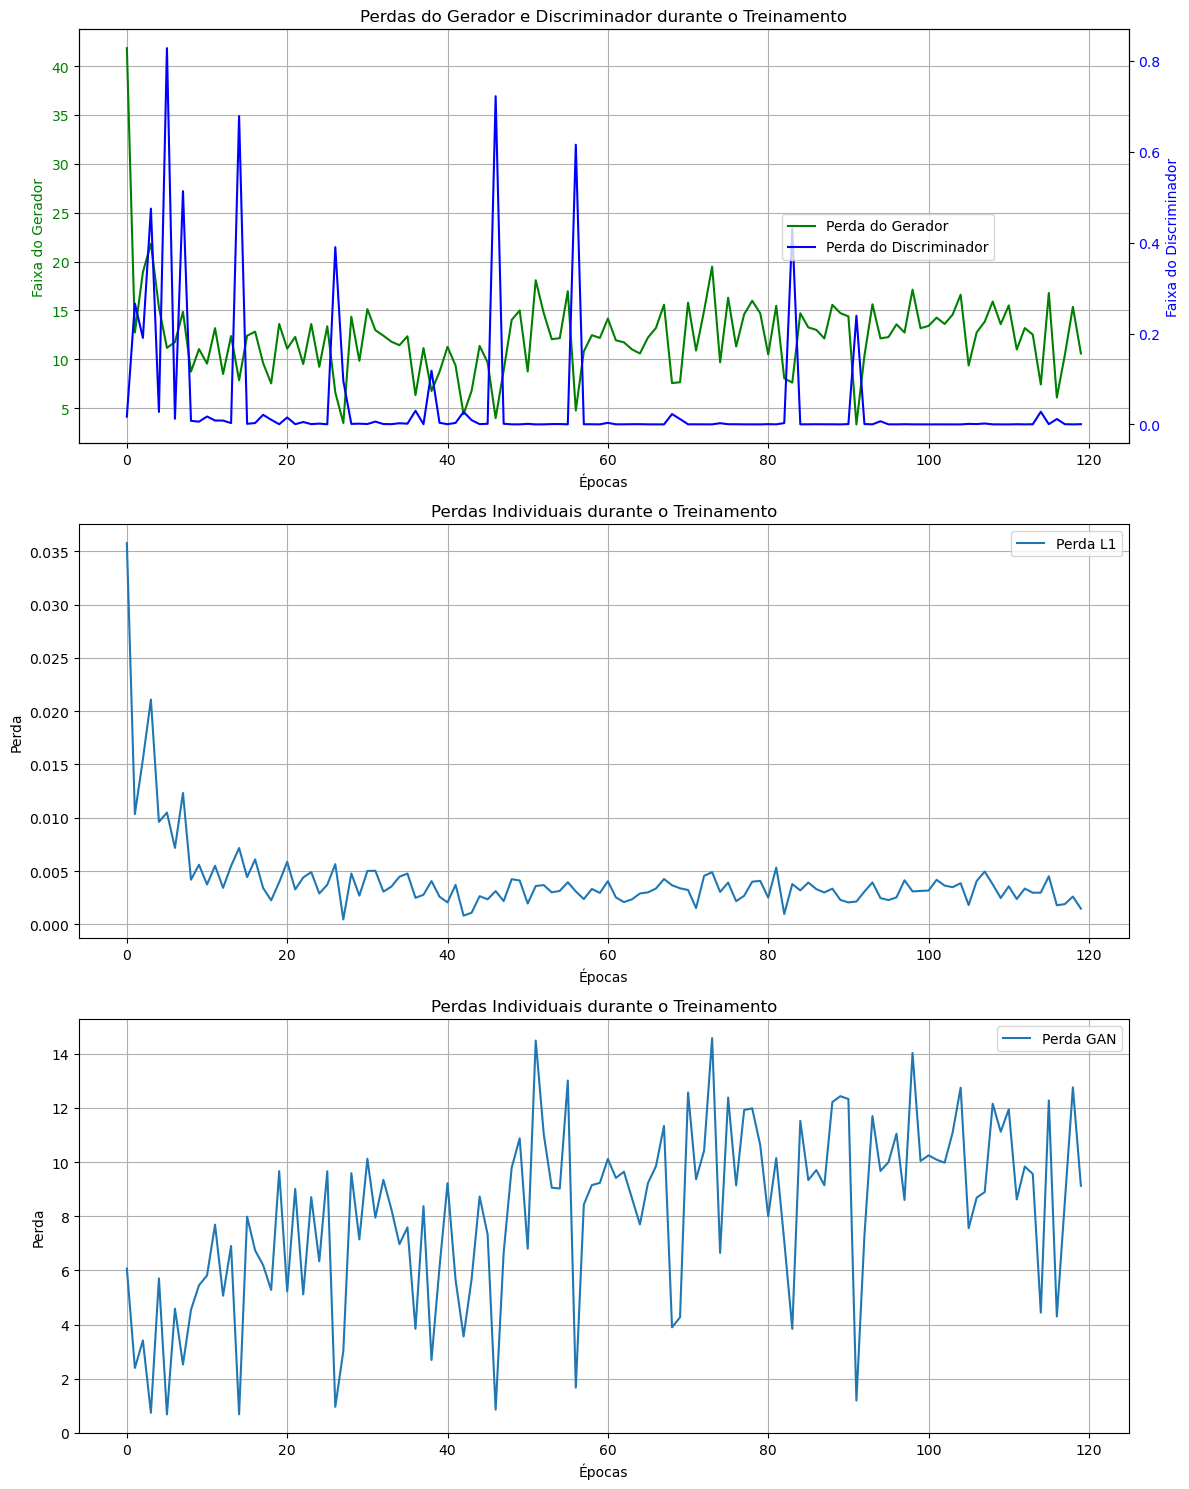

In [21]:
fig, (ax1, ax3, ax4) = plt.subplots(3,1, figsize=(12, 15))  # Definindo um layout de 1 linha e 2 colunas

# Primeiro gráfico: Perdas do Gerador e Discriminador
ax1.plot(G_losses, 'g-', label="Perda do Gerador")
ax1.set_xlabel("Épocas")
ax1.set_ylabel('Faixa do Gerador', color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax2 = ax1.twinx()
ax2.plot(D_losses, 'b-', label="Perda do Discriminador")
ax2.set_ylabel('Faixa do Discriminador', color='b')
ax2.tick_params(axis='y', labelcolor='b')
ax1.set_title("Perdas do Gerador e Discriminador durante o Treinamento")
ax1.grid()
fig.legend(loc='upper left',  bbox_to_anchor=(0.65, 0.858))

# Segundo gráfico: Perdas Individuais durante o Treinamento
ax3.plot(L1_losses, label="Perda L1")
ax3.set_xlabel("Épocas")
ax3.set_ylabel("Perda")
ax3.set_title("Perdas Individuais durante o Treinamento")
ax3.grid()
ax3.legend()

ax4.plot(GAN_losses, label="Perda GAN")
ax4.set_xlabel("Épocas")
ax4.set_ylabel("Perda")
ax4.set_title("Perdas Individuais durante o Treinamento")
ax4.grid()
ax4.legend()

# Salvando os gráficos
plt.tight_layout()  # Ajusta automaticamente o espaçamento
plt.savefig('pix2pix_P2VX_Loss_V2.png')
plt.show()

In [22]:
torch.save({
    'generator_state_dict': G.state_dict(),
    'discriminator_state_dict': D.state_dict(),
    'generator_optimizer_state_dict': optimizer_G.state_dict(),
    'discriminator_optimizer_state_dict': optimizer_D.state_dict(),
    'epoch': epoch
}, 'pix2pix_P2VXcheckpoint_V2.pth')

checkpoint = torch.load('pix2pix_P2VXcheckpoint_V2.pth', weights_only=True)